### Plotting Persistence Diagram and Barcode of a Point Cloud

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import ripser
from persim import plot_diagrams

plt.rcParams['figure.dpi'] = 500

In [3]:
# functions to generate point clouds

def make_circle(n_samples, radius:float=1, noise:float=0, random_seed:int=21):
  """
  Function to create a circle in 2D space
  :param: n_samples:   number of datapoints of sample
  :param: radius:      desired radius of circle
  :param: noise:       magnitude of noise sampled from uniform distribution
  :param: random_seed: set seed for "randomness"
  :return: circle of dimension (n_samples, 2)
  """
  np.random.seed(random_seed)
  theta = np.linspace(0, 2*np.pi, n_samples)
  X = radius * np.cos(theta) + (noise * np.random.uniform(0,1,n_samples))
  Y = radius * np.sin(theta) + (noise * np.random.uniform(0,1,n_samples))
  return np.transpose([X,Y])


def make_sphere(radius:float=1, noise:float=0, random_seed:int=21):
  """
  :param: radius:       desired radius of sphere
  :param: noise:        magnitude of noise sampled from uniform distribution
  :param: random_seed:  set seed for "randomness"
  :return: sphere of dimension (400, 3)
  """
  np.random.seed(random_seed)
  rho = radius
  theta, phi = np.mgrid[0:2*np.pi:20j, 0:np.pi:20j]
  x = rho * np.sin(phi) * np.cos(theta) + (noise * np.random.normal(0,1,size=(20,20)))
  y = rho * np.sin(phi) * np.sin(theta) + (noise * np.random.normal(0,1,size=(20,20)))
  z = rho * np.cos(phi) + (noise * np.random.normal(0,1,size=(20,20)))
  return np.array([x.flatten(), y.flatten(), z.flatten()]).transpose()

def make_torus(n_samples_sqrt:float, c:float, a:float, noise:float=0, random_seed:int=21):
  np.random.seed(random_seed)
  U, V = np.linspace(0, 2*np.pi, n_samples_sqrt), np.linspace(0, 2*np.pi, n_samples_sqrt)
  U, V = np.meshgrid(U, V)
  X = (c+a * np.cos(V))*np.cos(U) + (noise * np.random.normal(0,1, size=(n_samples_sqrt, n_samples_sqrt)))
  Y = (c+a * np.cos(V))*np.sin(U) + (noise * np.random.normal(0,1, size=(n_samples_sqrt, n_samples_sqrt)))
  Z = a*np.sin(V) + (noise * np.random.normal(0,1, size=(n_samples_sqrt, n_samples_sqrt)))
  return np.array([X.flatten(), Y.flatten(), Z.flatten()]).transpose()



In [27]:
# functions to plot barcode
import copy
import matplotlib.patches as mpatches
        
def min_birth_max_death(diagram:list) -> tuple:
    """
    :param: diagram: persistence diagram
    :return: (min_birth, max_death)
    """
    maxdim = len(diagram)
    min_birth, max_death = 0, 0
    for i in range(maxdim):
        diag = np.array(diagram[i])
        new = np.max(diag[diag!=np.inf])
        if max_death < new:
            max_death = new
    return min_birth, max_death

def plot_persistence_barcode(diag:list, maxdim:int, ax=None, title='', colormap=plt.cm.Set1.colors, alpha:float=0., delta:float=0.1,
                             yticks:list=None, yticks_label:str=None):
    min_birth, max_death = min_birth_max_death(diag[:maxdim+1])    
    new_diagram = copy.deepcopy(diag[:maxdim+1])
    new_diagram[0][-1,1] = max_death
    new_diagram = [sorted(new_diagram[i], key=lambda feature: (feature[0], feature[1]-feature[0])) for i in range(len(new_diagram))]

    # birth and death values (and color)
    x, y, c, dims = [], [], [], []
    for dim in range(len(new_diagram)):
        x.extend([birth for [birth, death] in new_diagram[dim]])
        y.extend([death-birth for [birth, death] in new_diagram[dim]])
        c.extend([colormap[dim] for [birth, death] in new_diagram[dim]])
        dims.extend([dim for [birth, death] in new_diagram[dim]])
    dimensions = {dim for dim in dims}

    # plotting
    ax = ax or plt.gca()
    if yticks is not None:
        ax.set_yticks(yticks, labels=yticks_label)
    ax.invert_yaxis()
    ax.set_xlim([min_birth-delta, max_death+delta])
    ax.set_xlabel('$\epsilon$')
    ax.set_title(title)
    ax.barh(range(len(x)), width=y, left=x, height=3, alpha=alpha, color=c, linewidth=0, edgecolor='k')
    # ax.legend(handles=[mpatches.Patch(color=colormap[dim], label=f'$H_{str(dim)}$') for dim in dimensions], loc='best')

    return x, y, c

In [51]:
# plot controls
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.dpi'] = 500
save_figs = True

In [ ]:
# instantiate the point clouds
sphere_data = make_sphere(radius=1, noise=0.2)
torus_data = make_torus(n_samples_sqrt=20, c=6, a=2, noise=0.1)

sphere_dgm = ripser.ripser(sphere_data, maxdim=2)['dgms']
torus_dgm = ripser.ripser(torus_data, maxdim=2)['dgms']

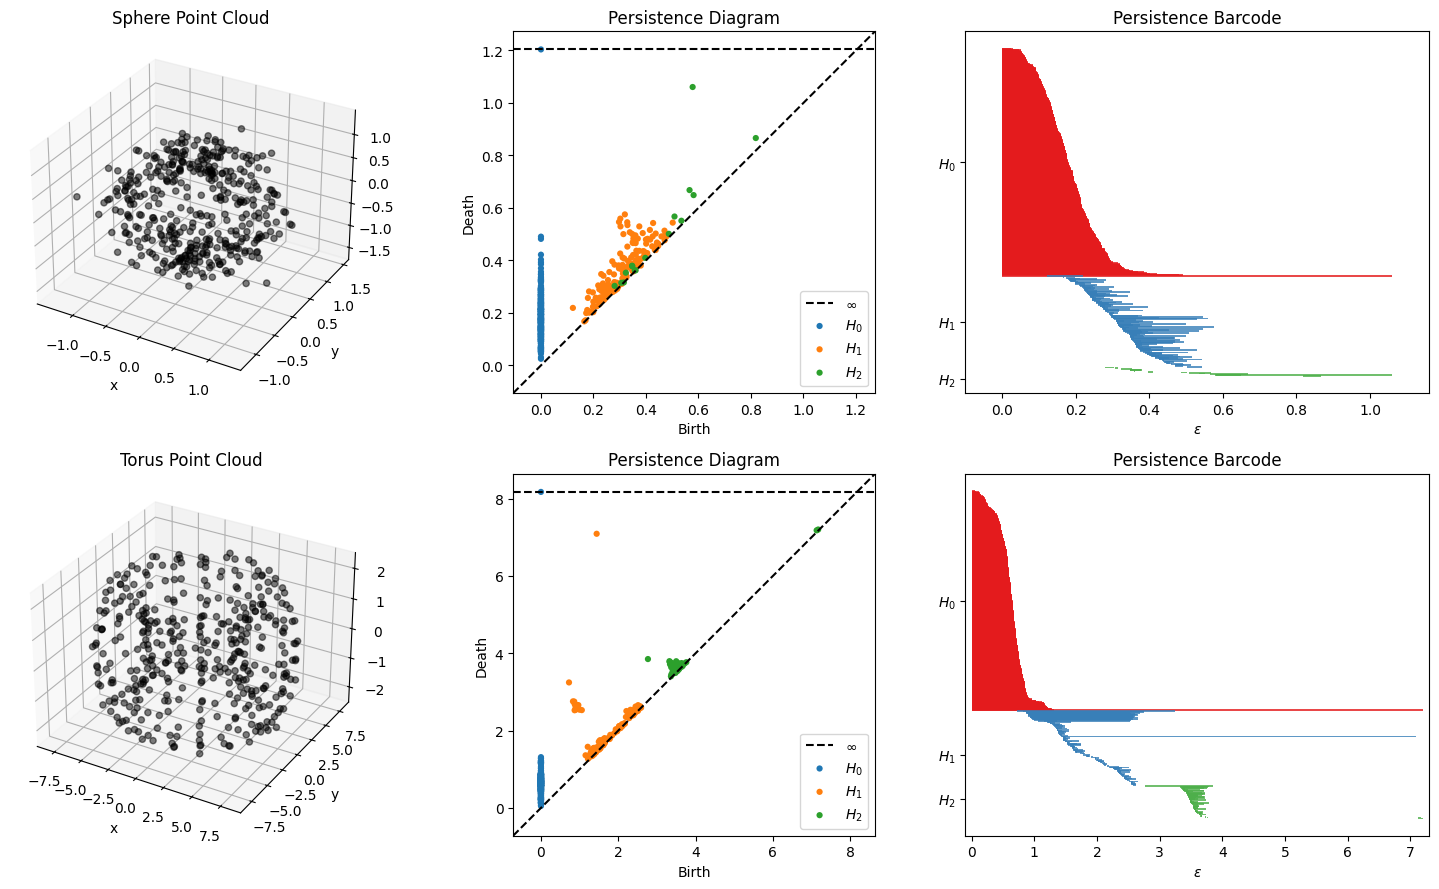

In [53]:
fig = plt.figure(figsize=(15,9))

# plot sphere, PD, and PB
ax1 = fig.add_subplot(2,3,1, projection='3d')
ax1.scatter(sphere_data[:,0], sphere_data[:,1], sphere_data[:,2], color='k', alpha=0.5)
ax1.set_title('Sphere Point Cloud')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2 = fig.add_subplot(2,3,2)
plot_diagrams(sphere_dgm, title='Persistence Diagram', ax=ax2)

ax3 = fig.add_subplot(2,3,3)
plot_persistence_barcode(sphere_dgm, maxdim=2, alpha=0.8, delta=0.1, title='Persistence Barcode', ax=ax3,
                         yticks=[200, 480, 580], yticks_label=[f"$H_{i}$" for i in range(3)])


# plot torus, PD, and PB
ax4 = fig.add_subplot(2,3,4, projection='3d')
ax4.scatter(torus_data[:,0], torus_data[:,1], torus_data[:,2], color='k', alpha=0.5)
ax4.set_title('Torus Point Cloud')
ax4.set_xlabel('x')
ax4.set_ylabel('y')

ax5 = fig.add_subplot(2,3,5)
plot_diagrams(torus_dgm, title='Persistence Diagram', ax=ax5)

ax6 = fig.add_subplot(2,3,6)
plot_persistence_barcode(torus_dgm, maxdim=2, alpha=0.8, delta=0.1, title='Persistence Barcode', ax=ax6,
                         yticks=[200, 480, 560], yticks_label=[f"$H_{i}$" for i in range(3)])

plt.tight_layout()
if save_figs:
    plt.savefig('figures/diagrams_and_barcode.png')
plt.show()

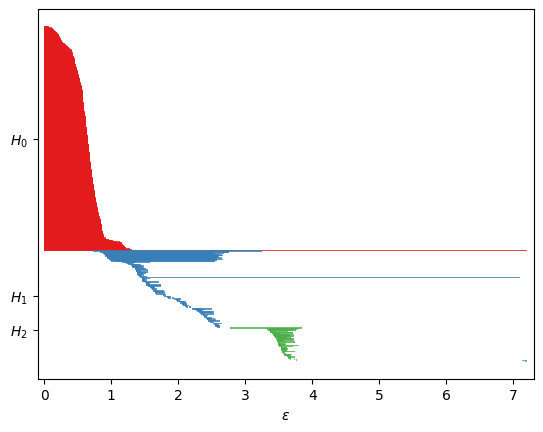

In [48]:
_ = plot_persistence_barcode(torus_dgm, maxdim=2, alpha=0.8, delta=0.1, yticks=[200, 480, 540], yticks_label=[f"$H_{i}$" for i in range(3)])
plt.show()